# Import Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# import the data
fake_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/Fake.csv")
true_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/True.csv")

# view first few rows for each 
print(fake_news.head())
print(true_news.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [6]:
# add labels
fake_news["label"] = "Fake"
true_news["label"] = "True"

# combine the two separate dataframes
news_df = pd.concat([fake_news, true_news], ignore_index = True)

# Data Cleaning


In [8]:
import string

# checking for missing values
print(news_df.isna().sum())

# converting letters to lowercase
news_df["title"] = news_df["title"].str.lower()
news_df["text"] = news_df["text"].str.lower()

# removing punctuation
news_df["title"] = news_df["title"].str.replace("[{}]".format(string.punctuation), "", regex = True)
news_df["text"] = news_df["text"].str.replace("[{}]".format(string.punctuation), "", regex = True)

# removing other special characters
news_df["title"] = news_df["title"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))
news_df["text"] = news_df["text"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))

# view cleaned dataset
print(news_df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                               title  \
0   donald trump sends out embarrassing new years...   
1   drunk bragging trump staffer started russian ...   
2   sheriff david clarke becomes an internet joke...   
3   trump is so obsessed he even has obamas name ...   
4   pope francis just called out donald trump dur...   

                                                text subject  \
0  donald trump just couldn t wish all americans ...    News   
1  house intelligence committee chairman devin nu...    News   
2  on friday it was revealed that former milwauke...    News   
3  on christmas day donald trump announced that h...    News   
4  pope francis used his annual christmas day mes...    News   

                date label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake  


In [9]:
import nltk

# tokenizing article text into words
tokenized_news = [nltk.word_tokenize(article) for article in news_df["text"]]

In [11]:
from nltk.corpus import stopwords

# removing stopwords
stop_words = set(stopwords.words("english"))

cleaned_articles = [[word for word in article if word not in stop_words] 
    for article in tokenized_news]

news_df["text"] = [" ".join(article) for article in cleaned_articles]
print((news_df["text"].head()))

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object


# EDA


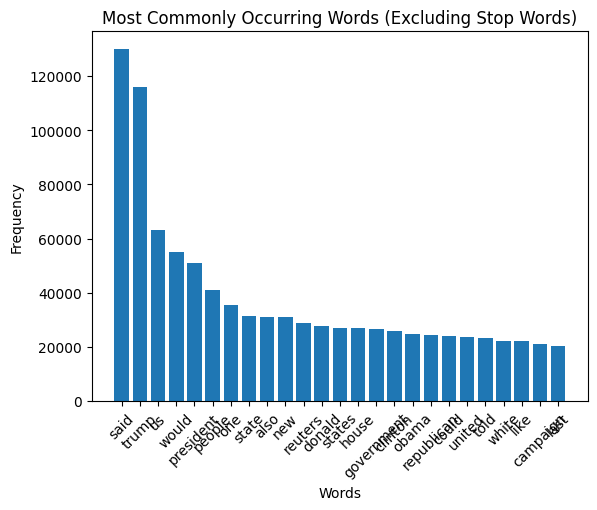

In [12]:
from collections import Counter
all_words = [word for article in cleaned_articles for word in article]
word_counts = Counter(all_words)

common_words = word_counts.most_common(25) 
words, counts = zip(*common_words)

plt.figure()
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Commonly Occurring Words (Excluding Stop Words)")
plt.xticks(rotation = 45)
plt.show()

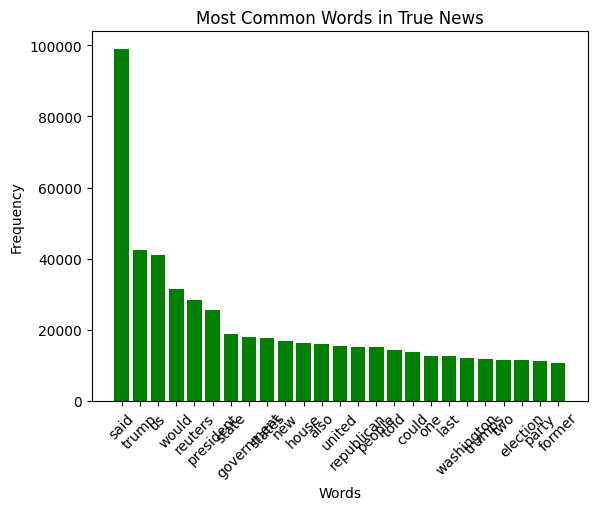

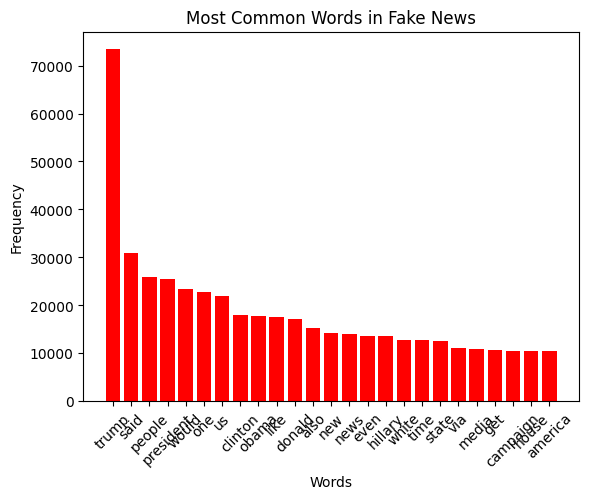

In [14]:
fake_articles = news_df[news_df.label == "Fake"]
fake_tokenized = [nltk.word_tokenize(article) for article in fake_articles["text"]]
fake_cleaned = [[word for word in article if word not in stop_words] 
    for article in fake_tokenized]
fake_words = [word for article in fake_cleaned for word in article]

true_articles = news_df[news_df.label == "True"]
true_tokenized = [nltk.word_tokenize(article) for article in true_articles["text"]]
true_cleaned = [[word for word in article if word not in stop_words] 
    for article in true_tokenized]
true_words = [word for article in true_cleaned for word in article]

fake_word_counts = Counter(fake_words)
true_word_counts = Counter(true_words)

fake_most_common = fake_word_counts.most_common(25) 
fake_words, fake_counts = zip(*fake_most_common)
true_most_common = true_word_counts.most_common(25) 
true_words, true_counts = zip(*true_most_common)

plt.close("all")

# plotting most common words in true reviews
plt.figure()
plt.bar(true_words, true_counts, color="green")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in True News")
plt.xticks(rotation = 45)
plt.show()

# plotting most common words in negative reviews
plt.figure()
plt.bar(fake_words, fake_counts, color="red")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Fake News")
plt.xticks(rotation = 45)
plt.show()

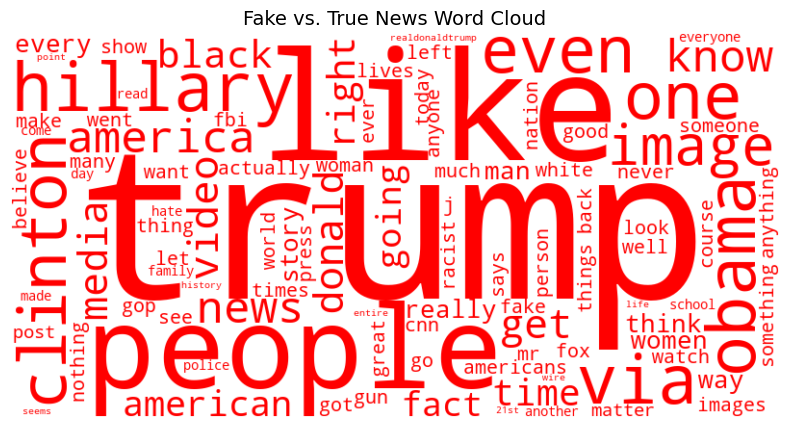

In [22]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import Word

word_freq = {
    word: fake_word_counts.get(word, 0) - true_word_counts.get(word, 0)
    for word in set(fake_word_counts) | set(true_word_counts)
}

# Custom color function with gradient
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    diff = word_freq.get(word, 0)  # Get Fake - True difference

    if diff > 0:  # More in Fake News
        red_intensity = min(255, int(255 * diff))  # Scale red intensity
        return f"rgb({red_intensity},0,0)"  # Red gradient

    elif diff < 0:  # More in True News
        blue_intensity = min(255, int(255 * abs(diff)))  # Scale blue intensity
        return f"rgb(0,0,{blue_intensity})"  # Blue gradient

    else:  # Appears equally in both
        return "rgb(128,128,128)"  # Gray

# Generate Word Cloud
wordcloud = WordCloud(
    width=800, height=400, max_words=100, background_color="white"
).generate_from_frequencies(word_freq)

# Apply custom coloring
wordcloud.recolor(color_func=color_func)

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Fake vs. True News Word Cloud", fontsize=14)
plt.show()